In [1]:
# The montecarlo modes could probably use some fiddling
# Now let's test that our sim still sims right

In [1]:
# Set up trapping fields for all sims this cell takes a minute to run as it initializes all the fields (Nr*Nz*3 values)
using Statistics,PyCall,PyPlot,CSV,DataFrames,DelimitedFiles
include("CollisionCodeFunctions.jl")
np = pyimport("numpy")

# Define useful constants
amu = 1.67e-27 ; eps0 = 8.854e-12 ; qe = 1.6e-19 # SI units 

# Define physical params
m = 40. *amu; q = 1. *qe; wr = 2*pi*3e6; wz = 2*pi*1e6 # SI units

# Define sim params
Nr = 20001 ; Nz = 20001 # number of cells related to trapping axis needs to be odd to allow null line
Nrmid = (Nr-1)/2 ; Nzmid = (Nz-1)/2 # middle cell which exists at r=0 (z=0) in physical units
Dr = Nr*1.5e-9 ; Dz = Nz*4.5e-9 # physical width in m of the sim
dr = Dr/float(Nr) ; dz = Dz/float(Nz) # width of a cell in z in m
Ezf = np.zeros((Nr, Nz)) ; Erf = np.zeros((Nr, Nz)) # array of electric fields s

# Here we'll make the DC and RF (pseudo)potentials
RF = makeRF0(m,q,wr,Nr,Nz,Nrmid,dr)
DC = makeDC(m,q,wz,Nz,Nr,Nzmid,dz)
Vfield = makeVField(m,q,wr,wz,Nr,Nz,Nrmid,Nzmid,dr,dz) # we add a matrix of the potential energy through our trap
nullFields = np.zeros((Nr,Nz))
println("constants set and modules imported") ; println("Simulation Size = ",Dr,"m in r x ",Dz,"m in z")

constants set and modules imported
Simulation Size = 3.00015e-5m in r x 9.00045e-5m in z


In [236]:
# Set up other constants
Ni = 2 # number of trapped ions
vf = np.zeros((Ni, 6)) # array of r,z,vr,vz,q,m for each ion in virtual units

# Here we describe how the collisional particles work
# they are a list of lists where the first index is the particle identifier
# the second index gives r,z,vr,vz,q,m,a (dipole moment)
aH2 = 8e-31 # dipole moment of H2 in SI units
mH2 = 2.0*amu # mass of H2 in kg

Nt = 90000 # number of time steps to take
dtSmall = 1e-14 ; dtMid = 1e-13 ; dtLarge = 2e-10 # length of a time step in s
dCutOut = 2*5000.0*dtLarge ; dCutIn = 2*5000.0*dtMid #such that the fastest particle we track can only get half-way in before switching regimes
Dt = dtSmall*Nt

# Now we add ions
l = 1 ; dsepz = 600*dz # starting separation between ions in physical units
vbumpr = 0 ; vbumpz = 0 # starting velocity in r and z of the lth ion in the chain
offsetr = 0 ; offsetz = 0 # starting distance from eq. in r and z of the lth ion in the chain

vf = makeVf(Ni,q,m,l,dsepz,offsetr,offsetz,vbumpr,vbumpz)

# add collisional particle list
Nc = 7
vc = np.zeros((Nc,7))
vc[:,6] .= 1e6
vc[1:end,1] .+= 2 ; vc[1:end,2] .+= 2

# We assign values for the laser cooling
c = 2.998e8 #speed of light in m/s
nu0 = 2*pi*c/729e-9 # atomic transition frequency
# vl = [1.0,0.0] #laser strictly radial
vl = [-1.0,0.0] #laser strictly radial
I0 = 10.e-3/(pi*1e-3^2) #laser intensity in W/m^2 I've used 20 mW in a 1mm diameter circle
dnul = 1e6# laser frequency width
A = 1.75e7 # einstein A coefficient for transition I've used the Nist table at 397.37nm
nul = 1.0*nu0 + A# laser center frequency
Ti = 1e-9 # transition lifetime

1.0e-9

vf = [0.0 2.7944999999999997e-6 0.0 0.0 1.6e-19 6.680000000000001e-26 0.0; 0.0 -2.7944999999999997e-6 0.0 0.0 1.6e-19 6.680000000000001e-26 0.0]
vr = 1500.0
vz = 9.184850993605149e-14
r = -1.4997e-5
z = 2.7949865211999998e-6
vr = 1500.0
vz = 9.184850993605149e-14
In laserInt: I0 = 3183.098861837907
nul = 2.5839492014402465e15
sigl = 1.0e6
A21 = 1.75e7
nua = 2.5839491839402465e15
fwhma = 2.7852115041081687e6
Position out of simulation in r 1.5001417955033695e-5 Particle # 1 vf = [1.5001417955033695e-5, -1.600871725415036e-5, 917.59371613087, -1150.1812099530327, 1.6e-19, 3.34e-27, 8.0e-31]
dt = 2.0e-10
-5.5894865189859625e-6


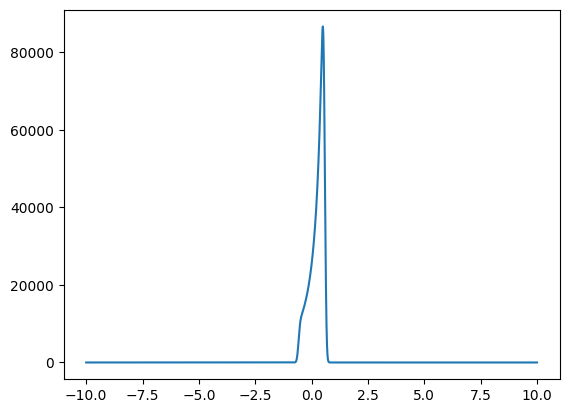

In [242]:
#This cell serves to test a single collision and inspect it in detail
include("CollisionCodeFunctions.jl")

P = 3e-8 ; T = 300 # pressure and temperature in SI units
sigmaV = 100e-6 # fall-off of potential outside trapping region
dv = 20.0 # bin size for particle speed in determining if collision occurs
vmax = 5000 # maximum particle speed we allow
Nrmid = (Nr-1)/2 ; Nzmid = (Nz-1)/2 ; first = 10 ; last=Nt
l = 1 ; dsepz = 2*(620+1)*dz # starting separation between ions in virtual units
vbumpr = 0.00e0 ; vbumpz = -0.0e0 # starting velocity in r and z of the lth ion in the chain
offsetz = 0.0e-7 ; offsetr = 0.0e-8 # starting distance from eq. in r and z of the lth ion in the chain
    
# We set all our initial values for the simulation
Ni=2
vf = makeVf(Ni,1.0*q,m,l,dsepz,offsetr,offsetz,vbumpr,vbumpz)
# vf = np.array([[1e-6,0.0e-7,0.0,0.0,q,m,0.0]])
println("vf = ",vf)
z = vf[1,2] + 0.4865212e-9 ; v = 1500 ; t =pi/2.0
vz=v*cos(t) ; vr = v*sin(t)
r = vtopPos(2,Nrmid,dr) #over-rode from 2 to allow collisions to occur faster
Nc = 1
# I need to check why the general oscillation of these ions is an order of magnitude different from the previous edition
    
println("vr = ",vr); println("vz = ",vz)
println("r = ",r); println("z = ",z); println("vr = ",vr); println("vz = ",vz)
rs,zs,vrs,vzs,rcolls,zcolls,vrcolls,vzcolls = runFasterCollision(vf,r,z,vr,vz,q,mH2,aH2,Nt,dtSmall,RF,DC,Nr,Nz,dr,dz,vl,I0,nul,dnul,nu0,A,Ti,dtLarge,dCutOut,dtMid,dCutIn,true)    

println((zs[2]-zcolls[1]))

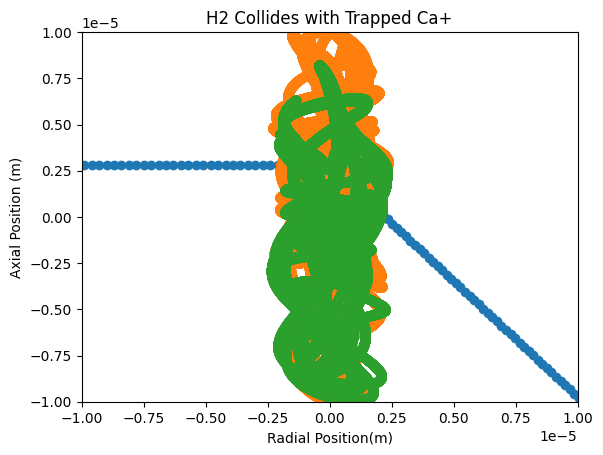

In [225]:
# This and the following plot show collision trajectories at different scales
first = 1;last = Nt
plotPieceWise(1,Ni,rcolls,rs,zcolls,zs,first,last,"H2 Collides with Trapped Ca+","Radial Position(m)","Axial Position (m)",-1e-5,1e-5,-1e-5,1e-5)


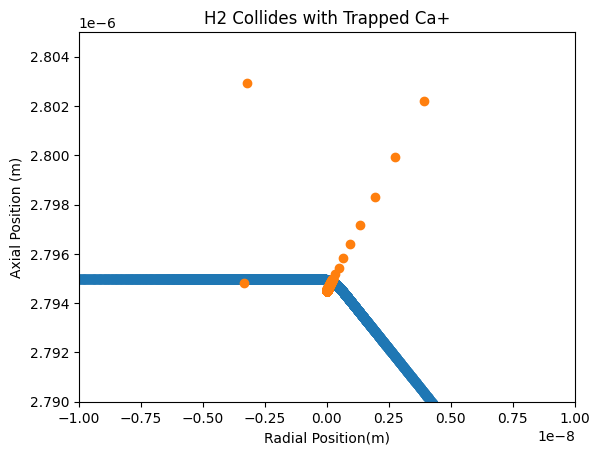

In [226]:
plotPieceWise(Nc,Ni,rcolls,rs,zcolls,zs,first,last,"H2 Collides with Trapped Ca+","Radial Position(m)","Axial Position (m)",-1e-8,1e-8,0.279e-5,0.2805e-5)


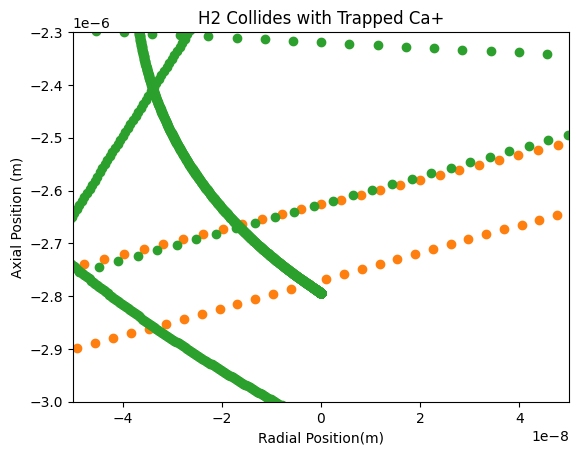

In [227]:
plotPieceWise(Nc,Ni,rcolls,rs,zcolls,zs,first,last,"H2 Collides with Trapped Ca+","Radial Position(m)","Axial Position (m)",-5e-8,5e-8,-0.30e-5,-0.23e-5)


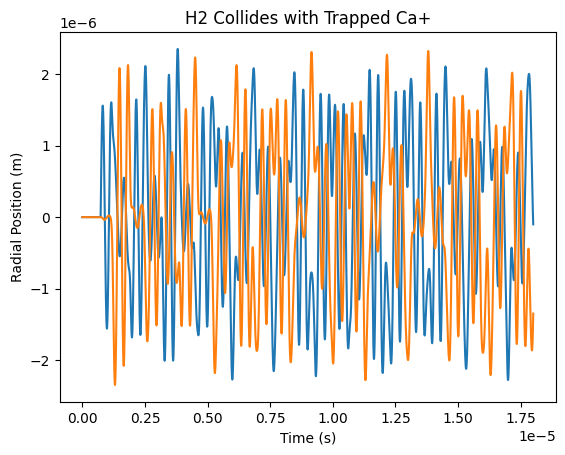

In [228]:
plotThing(0,Ni,dtLarge,rcolls,rs,first,last,"H2 Collides with Trapped Ca+","Time (s)","Radial Position (m)")

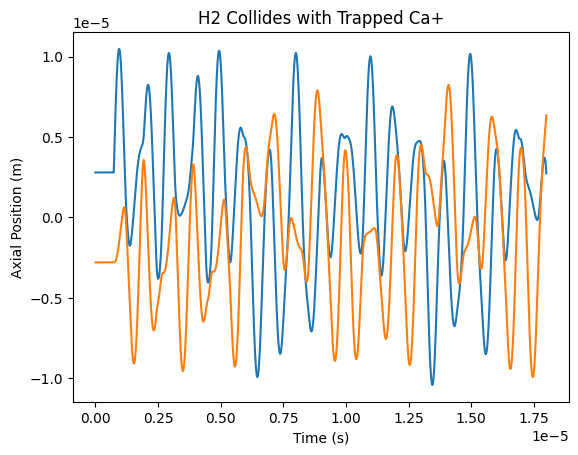

In [229]:
plotThing(0,2,dtLarge,zcolls,zs,first,last,"H2 Collides with Trapped Ca+","Time (s)","Axial Position (m)")

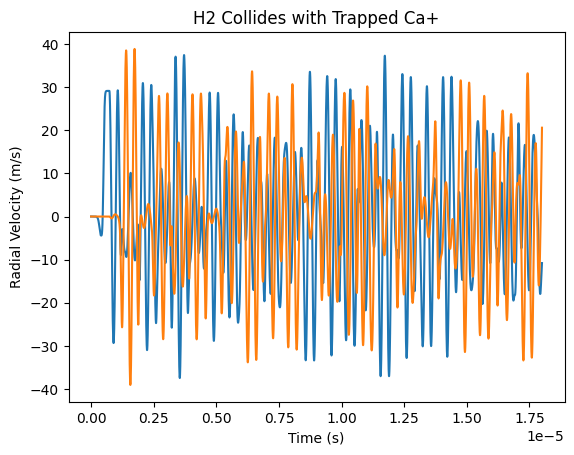

In [230]:
plotThing(0,Ni,dtLarge,vrcolls,vrs,first,last,"H2 Collides with Trapped Ca+","Time (s)","Radial Velocity (m/s)")

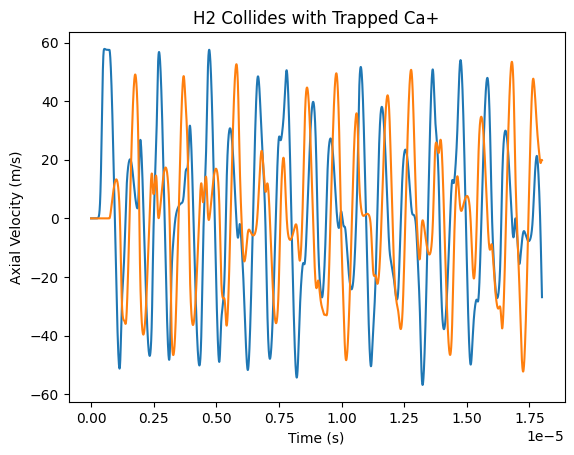

In [231]:
plotThing(0,Ni,dtLarge,vzcolls,vzs,first,last,"H2 Collides with Trapped Ca+","Time (s)","Axial Velocity (m/s)")

In [16]:
println("dr = ",dr)
println("dz = ",dz)

dr = 1.5e-9
dz = 4.5e-9


In [17]:
nummy = 5
rlow = convert(UInt32,Nrmid-nummy);rhigh = convert(UInt32,Nrmid+nummy)
zlow = convert(UInt32,Nzmid-nummy);zhigh = convert(UInt32,Nzmid+nummy)

println("RF = ",RF[rlow:rhigh,zlow:zhigh])
println("--")
println("DC = ",DC[rlow:rhigh,zlow:zhigh])

LoadError: BoundsError: attempt to access 11×11 Matrix{Float64} at index [0x0000270b:0x00002715, 0x0000270b:0x00002715]

In [18]:
# Here is where I will build my test cases
include("CollisionCodeFunctions.jl")

# First the conversions
x = -0.25
vx = ptovPos(x,50,0.01)
px = vtopPos(vx,50,0.01)
println("x = ",x," vx = ",vx," px = ",px)

# Then the makeVf
vftest = makeVf(2,q,m,1,4.0e-6,1.0e-7,1.0e-7,1.0e-3,1.0e-3) ; println("vftest = ",vftest)

# We test the Field generators
Nrtest = 11 ; Nztest = 11 ; Nrmidtest = (Nrtest+1)/2 ; Nzmidtest = (Nztest+1)/2 ; drtest = 1.0e-6/Nrtest ; dztest = 10.0e-6/Nztest
RF = makeRF0(m,q,1e7,Nrtest,Nztest,Nrmidtest,drtest) ; println("RF = ",RF,"\n")
DC = makeDC(m,q,1e6,Nztest,Nrtest,Nzmidtest,dztest) ; println("DC = ",DC,"\n")
nullFields = np.zeros((Nrtest,Nztest))
Vtest = makeVField(m,q,1e7,1e6,Nrtest,Nztest,Nrmidtest,Nzmidtest,drtest,dztest) ; println("Vtest = ",Vtest,"\n")

# Then the solveFields
Etestr2,Etestz2 = solveFields(vftest,nullFields,DC,RF,nullFields,Nrmidtest,Nzmidtest,Ni,drtest,dztest) ; println("Etestr2 = ",Etestr2," Etestz2 = ",Etestz2)

testEr,testEz = ACFields(1.0,1.0,pi/2,1e6,0.0) ; println("Er = ",testEr," Ez = ",testEz)
testEr,testEz = ACFields(1.0,1.0,pi/2,1e6,2.5e-7) ; println("Er = ",testEr," Ez = ",testEz)
testEr,testEz = ACFields(1.0,1.0,pi/2,1e6,5e-7) ; println("Er = ",testEr," Ez = ",testEz)
testEr,testEz = ACFields(1.0,1.0,pi/2,1e6,7.5e-7) ; println("Er = ",testEr," Ez = ",testEz)

# Then minDists and if we're in collisionMode
rid,rii,vid,vii = minDists(vf,vc) ; println("rid = ",rid," rii = ",rii," vid = ",vid," vii = ",vii)
collision = collisionMode(1,1,vc[1,7],0.1) ; println("Collision False = ",collision)
collision = collisionMode(1,1e-8,vc[1,7],0.1) ; println("Collision True = ",collision)

# Then updateVels and updatePoss
dttest = 1e-9
vftest1 = updateVels(vf,Etestr2,Etestz2,dttest,Nrmidtest,Nzmidtest) ; println("vftest1 = ",vftest1)
vftest2 = updatePoss(vf,drtest,dztest,dttest,Nrtest,Nztest,Nrmidtest,Nzmidtest) ; println("vftest2 = ",vftest2)

# Then E and P calcs
Etest = particleE(1/sqrt(2),1/sqrt(2),1.0) ; println("Etest = ",Etest)
Ptest = particleP(1.0/sqrt(2),1.0) ; println("Ptest = ",Ptest)
Eprpztest = totalEandP([1.0,-1.0],[-1.0,-1.0],1.0) ; println("Eprpztest = ",Eprpztest)

# farApart
vctestfar = np.array([[0.0,0.0e-7,0.0,0.0,q,m,aH2]])
vctestclose = np.array([[0.0,2.8e-6,0.0,0.0,q,m,aH2]])
farCheck = farApart(vftest,vctestfar,1e-6) ; println("farCheck = ",farCheck)
farCheck = farApart(vftest,vctestclose,1e-6) ; println("farCheck = ",farCheck,"\n")

# laserInt
nuTest1 = laserInt(m,1.0,4e14+1e7,1e6,1e7,4e14,1e7,2000,10,101,10) ;
nuTest2 = laserInt(m,1.0,4e14-1e7,1e6,1e7,4e14,1e7,2000,10,101,10) ;

# laserCooling
vftest3 = laserCoolSmoothNew(vftest2,[1/sqrt(2),1/sqrt(2)],nuTest1,2,1e-9); println("vftest3 = ",vftest3)

# collisionParticlesFields
vc,Erfi,Ezfi,Erfc,Ezfc = collisionParticlesFields(vftest3,vctestclose,2,nullFields,DC,RF,nullFields,drtest,dztest,1e-9,Nrmidtest,Nzmidtest) ; println("Erfi = ",Erfi," Ezfi = ",Ezfi," Erfc = ",Erfc," Ezfc = ",Ezfc)

test = 4


In [ ]:
# The plot tests need to each be in their own cell for display purposes
# plots
first = 1 ; last = 100 ; xlabel1 = "TestX" ; ylabel1 = "TestY1" ; ylabel2 = "TestY2" ; title1 = "Test Title"
xlow = -10.0; xhigh = 10.0; ylow = -10.0; yhigh = 10.0
colls = np.transpose(np.arange(first,last+1,1).*np.ones((1,1))) ; ions = np.transpose(np.arange(last+1,first,-1).*np.ones((1,1)))
plotThing(1,1,1e-9,colls,ions,first,last,title1,xlabel1,ylabel1)

In [ ]:
thing1 = np.transpose(np.arange(first,last+1,1).*np.ones((1,1))) ; thing2 = np.transpose(np.arange(last+1,first,-1).*np.ones((1,1)))
subPlotThings(1,1,1e-9,thing1,thing2,first,last,title1,xlabel1,ylabel1,ylabel2)

In [ ]:
colls1 = np.transpose(np.arange(10,-10,-0.2).*np.ones((1,1))) ; ions1 = np.transpose(np.arange(10,-10,-0.2).*np.ones((1,1)))  ; colls2 = np.transpose(np.arange(10,-10,-0.2).*np.ones((1,1))) ; ions2 = np.transpose(np.arange(-10,10,0.2).*np.ones((1,1))) 
plotPieceWise(1,1,colls1,ions1,colls2,ions2,first,last,title1,xlabel1,ylabel1,xlow,xhigh,ylow,yhigh)